In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import preprocessing
import urllib2
import numpy as np
import re, string
import time
import urllib2
from ipywidgets import widgets
from IPython.display import display, clear_output
import unicodedata
import matplotlib.pyplot as plt

In [2]:
#function that removes accent marks
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [3]:
#function that determines the last 10 letters of a word, outputs binary numpy array of length 260
def count(word):
    count=[float(word[-1:].lower().count(letter)) for letter in list(string.ascii_lowercase)]
    for k in range(2,11):
        count = count + [float(word[-k:-k+1].lower().count(letter)) for letter in list(string.ascii_lowercase)]
    return np.array(count) 

In [4]:
#Loading texts "Os Maias" (Portuguese), "Don Quijote" (Spanish), "Pride and Prejudice" (English)
#from Project Gutenberg, outputs list of words
response_por = urllib2.urlopen('http://www.gutenberg.org/cache/epub/40409/pg40409.txt')
response_spa = urllib2.urlopen('http://www.gutenberg.org/cache/epub/2000/pg2000.txt')
response_eng = urllib2.urlopen('http://www.gutenberg.org/files/1342/1342-0.txt')
#Cleaning data
raw_por = response_por.read()[2321:-22083]
raw_spa = response_spa.read()[28614:-19240]
#raw_eng = response_eng.read()[721:-19210]
text_por=re.sub(r'[^\w\s]','',strip_accents(unicode(raw_por, "utf-8"))).split()
text_spa=re.sub(r'[^\w\s]','',strip_accents(unicode(raw_spa, "utf-8"))).split()
#text_eng=re.sub(r'[^\w\s]','',strip_accents(unicode(raw_eng, "utf-8"))).split()

In [5]:
#Mapping count function to the first num_words words
num_words = 40000
count_por = map(count, text_por[:num_words])
count_spa = map(count,text_spa[:num_words])

In [6]:
#Splitting the data into blocks of size len_block, mimicking short sentences
len_block = 5
num_words = 5000
x_por = [count_por[i:i+len_block] for i in range(0,num_words,len_block)]
x_spa = [count_spa[i:i+len_block] for i in range(0,num_words,len_block)]

#Initializing target values
y_por = [0]*len(x_por)
y_spa = [1]*len(x_spa)

#Combining data from both languages
x_all = np.array(x_por+x_spa)
y_all = np.array(y_por+y_spa)

len(y_all)

2000

In [7]:
#Function that computes the probability that a vector is from a certain language
#Inputs are a list of neural networks classifiers (models), PCA algorithm (pca), 
#vector with count() values for each word
#returns (probability Portuguese, probability Spanish)
def probability(models, pca, vec):
    probs = [model.predict_proba(pca.transform(vec)) for model in models]
    #simple average over probabilities from each word and each model
    return np.array(probs).mean(axis=0).mean(axis=0)

In [8]:
#5-fold cross validation

#pick random folds
kf = KFold(n_splits=5, shuffle = True)

#overall misclassification rate
overall = 0

for train_ind, test_ind in kf.split(x_all):
    t0=time.time()
    
    #divide data into training and cross validation sets
    x_train = np.array(x_all[train_ind])
    y_train = np.array(y_all[train_ind])
    x_cv = np.array(x_all[test_ind])
    y_cv = np.array(y_all[test_ind])
        
    #transform blocks of words in the training data into individual words
    x_train_sub = [x for lista in x_train for x in lista]
    y_train_sub = [value for value in y_train for _ in range(0,len_block)]
    
    #do PCA on the training data
    pca = PCA(n_components=140)
    pca.fit(x_train_sub)
    
    #list of models
    models = []
    
    #loop to train each model
    for i in range(1,6):        
        clf = MLPClassifier(solver='lbfgs', alpha=1e-4, activation = 'logistic',
                     hidden_layer_sizes=(30), random_state=i)
        clf.fit(pca.transform(x_train_sub), y_train_sub)
        models.append(clf)
    
    #compute the probabilities for each instance of cross validation
    probs = map(lambda x: probability(models,pca, x), x_cv)
    
    #predict the language with the highest probability
    pred = np.argmax(probs,axis=1)
    
    #number of misclassified examples
    result = (np.array(pred) != np.array(y_cv)).sum()
    #total examples
    tot = len(y_cv)
    
    overall = overall+float(result)/(5*tot)
    
    #print misclafication rate for the current cv fold
    print('Missed '+str(result)+' out of '+str(tot))
    t1=time.time()
    print(str(t1-t0)+' seconds')

#print overall misclassification rate
print('Miss rate: '+str(100*overall)+'%')

Missed 10 out of 400
32.3840000629 seconds
Missed 8 out of 400
32.756000042 seconds
Missed 1 out of 400
32.3159999847 seconds
Missed 7 out of 400
32.9839999676 seconds
Missed 7 out of 400
32.5920000076 seconds
Miss rate: 1.65%


In [10]:
#Training the final model

#Initializing the training data
num_words = 32000
x_train_por = count_por[:32000]
x_train_spa = count_spa[:32000]
y_train_por = [0]*len(x_train_por)
y_train_spa = [1]*len(x_train_spa)
x_train = np.array(x_train_por+x_train_spa)
y_train = np.array(y_train_por+y_train_spa)
    
#PCA on training data
pca = PCA(n_components=140)
pca.fit(x_train)
    
models = []

#Training 5 neural networks using different seeds for randomness
for i in range(1,6):
    t0=time.time()
    clf = MLPClassifier(solver='lbfgs', alpha=1e-4, activation = 'logistic',
                     hidden_layer_sizes=(30), random_state=i)
    clf.fit(pca.transform(x_train), y_train)
    models.append(clf)
    
    t1=time.time()
    print(str(t1-t0)+' seconds')

44.4110000134 seconds
46.4070000648 seconds
45.3429999352 seconds
45.521999836 seconds
44.998000145 seconds


In [11]:
#Computing misclassification rate for different block lengths

#list of misclassification percentages for different block lengths
miss_rate = []

for len_block in range(1,11):
    
    #Initializing test data for each block length
    num_words = 39000
    x_test_por = [count_por[i:i+len_block] for i in range(33000,num_words,len_block)]
    x_test_spa = [count_spa[i:i+len_block] for i in range(33000,num_words,len_block)]
    y_test_por = [0]*len(x_test_por)
    y_test_spa = [1]*len(x_test_spa)

    x_test = np.array(x_test_por+x_test_spa)
    y_test = np.array(y_test_por+y_test_spa)
    
    #compute probabilities on test data
    probs = map(lambda x: probability(models, pca, x), x_test)
    
    #predict language with highest probability
    pred = np.argmax(probs,axis=1)
    
    #number of misclassified examples
    result = float((np.array(pred) != np.array(y_test)).sum())
    #total examples
    tot = len(y_test)
    
    #misclassification percentage
    rate = float(100*result/tot)
    
    miss_rate.append(rate)
    
    print('Miss rate (len_block = ' + "%d" % len_block + "): " "%.2f" % rate + "%")

Miss rate (len_block = 1): 17.53%
Miss rate (len_block = 2): 8.12%
Miss rate (len_block = 3): 4.60%
Miss rate (len_block = 4): 2.50%
Miss rate (len_block = 5): 1.46%
Miss rate (len_block = 6): 1.00%
Miss rate (len_block = 7): 0.47%
Miss rate (len_block = 8): 0.27%
Miss rate (len_block = 9): 0.60%
Miss rate (len_block = 10): 0.25%


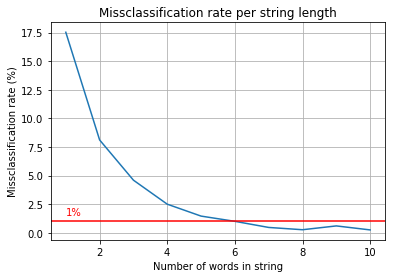

In [12]:
#Plotting variation of misclassification rate per string length

plt.plot(range(1,11), miss_rate)

plt.xlabel('Number of words in string')
plt.ylabel('Missclassification rate (%)')
plt.title('Missclassification rate per string length')
#added horizontal line with 1% threshold
plt.axhline(1,color='r')
plt.grid(True)
plt.annotate('1%', 
             color = 'red',
             xy=(1, 1.5))
plt.show()

In [13]:
#function that receives a list of models, PCA from training data and a string s
#outputs the languages the string was written in
def parse_str(models,pca,s):
    words = re.sub(r'[^\w\s]','',strip_accents(unicode(s, "utf-8"))).split()
    probs = probability(models, pca, map(count,words))
    if probs[0]>0.5:
        print('Portuguese')
    else:
        print('Spanish')

In [14]:
#trying it out with some newspapers headlines
sentence = 'Corbyn pide la dimisión de May por los recortes en seguridad'

parse_str(models,pca,sentence)

Spanish


In [15]:
sentence = 'Corbyn pede a demissão de May por ter despedido 20 mil polícias'

parse_str(models,pca,sentence)

Portuguese
